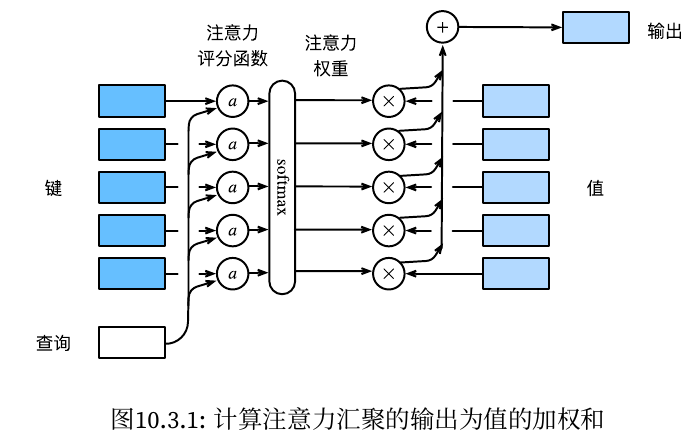

In [2]:
import  math
import torch
from torch import nn
from dltool import plot

# 掩蔽softmax

In [3]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [4]:
def masked_softmax(X, valid_lens):
  """通过在最后一个轴上掩蔽元素来执行softmax操作"""
  # X:3D张量，valid_lens:1D或2D张量
  if valid_lens is None:
    return nn.functional.softmax(X, dim=-1)
  else:
    shape = X.shape
    if valid_lens.dim() == 1:
      valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else:
      valid_lens = valid_lens.reshape(-1)
    # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而使得softmax输出为0
    X = sequence_mask(X.reshape(-1,shape[-1]), valid_lens, value=-1e6)
    return nn.functional.softmax(X.reshape(shape),dim=-1)


In [5]:
# 演示masked_softmax
# 两个2x4矩阵表示的样本
# 有效长度为2，3，经过掩蔽softmax运算，超出有效长度的值都被掩蔽为0
masked_softmax(torch.rand(2,2,4), torch.tensor([2,3]))

tensor([[[0.4545, 0.5455, 0.0000, 0.0000],
         [0.5553, 0.4447, 0.0000, 0.0000]],

        [[0.3380, 0.3410, 0.3210, 0.0000],
         [0.3634, 0.4045, 0.2321, 0.0000]]])

# 加性注意力
适合查询和键的长度不同的情况，使用加性注意力作为评分函数。
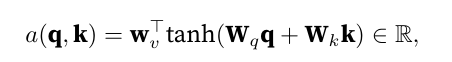
- 查询q，键k
查询和键连结起来输入到一个MLP中，就一个隐藏层

In [6]:
class AdditiveAttention(nn.Module):
  """加性注意力"""
  def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
    super(AdditiveAttention, self).__init__(**kwargs)
    self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
    self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
    self.w_v = nn.Linear(num_hiddens,1, bias=False)
    self.dropout = nn.Dropout(dropout)
  
  # valid_lens:多少对key-value对是需要的
  def forward(self, queries, keys, values, valid_lens):
    queries, keys = self.W_q(queries), self.W_k(keys)
    # 在维度扩展后
    # queries的形状：(batch_size, 查询的个数， 1, num_hidden)
    # key的形状：(batch_size, 1, "键-值"的个数，num_hidden)
    # 广播方式求和
    features = queries.unsqueeze(2) + keys.unsqueeze(1)
    features = torch.tanh(features)
    # self.w_v仅有一个输出,因此从形状中移除最后那个维度。
    # scores的形状:(batch_size,查询的个数,“键-值”对的个数)
    scores = self.w_v(features).squeeze(-1)
    self.attention_weights = masked_softmax(scores, valid_lens)
    # values的形状：(batch_size, "键值对的个数"，值的维度)
    return torch.bmm(self.dropout(self.attention_weights), values)
    

In [7]:
queries , keys = torch.normal(0,1,(2,1,20)), torch.ones((2,10,2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1,10,4).repeat(2,1,1)
valid_lens = torch.tensor([2,6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

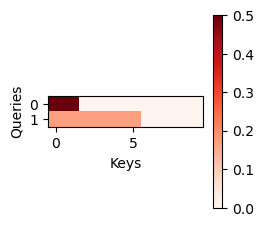

In [8]:
plot.show_heatmaps(attention.attention_weights.reshape((1,1,2,10)),
                   xlabel='Keys',ylabel='Queries')

# 缩放点积注意力


In [12]:
class DotProductAttention(nn.Module):
  """缩放点积注意力"""
  def __init__(self, dropout, **kwargs):
    super(DotProductAttention, self).__init__(**kwargs)
    self.dropout = nn.Dropout(dropout)
  
  # queries的形状:(batch_size,查询的个数,d),
  # keys的形状:(batch_size,键值对的个数,d),
  # values的形状:(batch_size,键值对的个数,值的维度)
  # valid_lens的形状:(batch_size,),或者(batch_size,查询的个数)
  def forward(self, queries, keys, values, valid_lens=None):
    d = queries.shape[-1]
    # 设置transpose_b=True为了交换keys的最后两个维度
    scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [26]:
# 交换维度1和维度2
print(keys.shape,'\n',keys)
print(keys.transpose(1,2).shape,'\n',keys.transpose(1,2))


torch.Size([2, 10, 2]) 
 tensor([[[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]])
torch.Size([2, 2, 10]) 
 tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])


In [13]:
queries = torch.normal(0,1,(2,1,2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

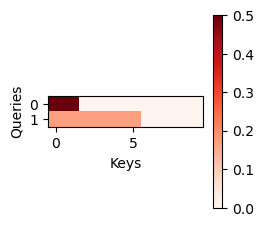

In [20]:
plot.show_heatmaps(attention.attention_weights.reshape((1,1,2,10)),xlabel='Keys',ylabel='Queries')

In [22]:
attention.attention_weights

tensor([[[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000,
          0.0000, 0.0000]]])